## GENERATE ERRORS CSV

In [1]:
import glob
import os
import json
import collections

# import seaborn as sns
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from scipy import linalg
from matplotlib.patches import Ellipse
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
%cd ./position_angle_error_details                           # cd to this folder

## SAVE errors_dataframe.csv WHICH WILL BE USED TO CREATE THE SA LABELS

This reads from all the json files that were created using "errors.py" (stored in position angle error details) and compiles the necessary information into a csv file for further processing

In [11]:
max_missed_aircrafts = 0
d = {}
d["name"] = []
d["position_error"] = []
d["angle_error"] = []
d["normalized_position_error"] = []
d["normalized_angle_error"] = []
d["num_aircrafts_for_normalization"] = []
d["number_of_missed_aircrafts"] = []
d["intersection_distances"] = []
d["distances_from_red_aircraft"] = []
d["num_aircrafts"] = []

for folder in glob.glob("./*"):
    for file in glob.glob(os.path.join(folder, "*")):
        with open(file, "r") as f:
            data = json.load(f)
            num_aircrafts = int(file[20]) + 1
            position_error = data["sum_of_l2"]
            angle_error = data["abs_sum_of_angles_diff"]
            num_missed_aircraft = data["number_of_missed_aircrafts"]
            intersection_distances = data["intersection_distances"]
            distances = data["distances_from_red_aircraft"]
            max_missed_aircrafts = max(max_missed_aircrafts, num_missed_aircraft)
            num_guessed_aircrafts = num_aircrafts - num_missed_aircraft
            if len(intersection_distances) == 0:
                d["name"].append(file)
                d["position_error"].append(position_error)
                d["angle_error"].append(angle_error)
                d["num_aircrafts"].append(num_aircrafts)
                d["number_of_missed_aircrafts"].append(num_missed_aircraft)
                d["num_aircrafts_for_normalization"].append(num_guessed_aircrafts)
                d["normalized_position_error"].append(position_error / num_guessed_aircrafts)
                d["normalized_angle_error"].append(angle_error / num_guessed_aircrafts)
                d["intersection_distances"].append(0)
                d["distances_from_red_aircraft"].append(0)
            else:
                for i in range(len(intersection_distances)):
                    if intersection_distances[i] == -float("inf") or intersection_distances[i] == float("inf"):
                        intersection_distances[i] = 1.0
                        distances[i] = 1.0
                    print(file)
                    d["name"].append(file)
                    d["position_error"].append(position_error)
                    d["angle_error"].append(angle_error)
                    d["num_aircrafts"].append(num_aircrafts)
                    d["number_of_missed_aircrafts"].append(num_missed_aircraft)
                    d["num_aircrafts_for_normalization"].append(num_guessed_aircrafts)
                    d["normalized_position_error"].append(position_error / num_guessed_aircrafts)
                    d["normalized_angle_error"].append(angle_error / num_guessed_aircrafts)
                    d["intersection_distances"].append(intersection_distances[i])
                    d["distances_from_red_aircraft"].append(distances[i])


./1566954358/Task_1_5_5_secondary.json
./1566954358/Task_1_5_1_secondary.json
./1566954358/Task_1_5_2.json
./1566954358/Task_1_5_4_secondary.json
./1566954358/Task_1_5_7.json
./1566954358/Task_1_5_3_secondary.json
./9115601756/Task_1_5_9_secondary.json
./9115601756/Task_1_5_7.json
./7799738638/Task_1_5_8.json
./7799738638/Task_1_5_4_secondary.json
./7799738638/Task_1_5_9.json
./7799738638/Task_1_5_6.json
./5843924292/Task_1_5_8.json
./5843924292/Task_1_5_9_secondary.json
./5843924292/Task_1_5_6_secondary.json
./5843924292/Task_1_5_7_secondary.json
./7538467423/Task_1_5_8_secondary.json
./4741106167/Task_1_5_8.json
./4741106167/Task_1_5_8.json
./4741106167/Task_1_3_6.json
./4741106167/Task_1_3_1.json
./4741106167/Task_1_1_8.json
./4741106167/Task_1_5_1_secondary.json
./4741106167/Task_1_5_1_secondary.json
./4741106167/Task_1_5_7_secondary.json
./4741106167/Task_1_1_6.json
./4741106167/Task_1_3_10.json
./4741106167/Task_1_3_2_secondary.json
./4741106167/Task_1_3_5.json
./4741106167/Task_

In [2]:
print(len(d["name"]))
print(len(d["position_error"]))
print(len(d["angle_error"]))
print(len(d["normalized_position_error"]))
print(len(d["normalized_angle_error"]))
print(len(d["num_aircrafts_for_normalization"]))
print(len(d["number_of_missed_aircrafts"]))
print(len(d["num_aircrafts"]))
print(len(d["intersection_distances"]))
print(len(d["distances_from_red_aircraft"]))

In [5]:
c = collections.Counter(d["number_of_missed_aircrafts"])
c

Counter({0: 577, 1: 102, 2: 13, 3: 1})

In [13]:
df = pd.DataFrame.from_dict(d)
df.to_csv("../errors_dataframe.csv", index=False)

## FULL SA LABEL GENERATION PIPELINE

GENERATE LABELS

In [1]:
import glob
import os
import json
import collections

import seaborn as sns
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from scipy import linalg
from matplotlib.patches import Ellipse
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

Read the csv file into a dataframe df_not_missed

In [3]:
df_not_missed = pd.read_csv("errors_dataframe.csv")
df_not_missed.shape

(708, 10)

df_missed is a dataframe that contains only trails where the subject missed an aircraft

In [4]:
df_missed = df_not_missed[df_not_missed["number_of_missed_aircrafts"] != 0]
print(df_missed.shape)
print(df_not_missed.shape)

(131, 10)
(708, 10)


In [5]:
X_not_missed = df_not_missed[['normalized_position_error', 'normalized_angle_error']].to_numpy()
X_missed = df_missed[['distances_from_red_aircraft', 'intersection_distances']].to_numpy()
print(X_not_missed.shape)
print(X_missed.shape)

(708, 2)
(131, 2)


Plot the normalized position and angle errors of every trial by every subject in Task 1 (normalized by the number of aircrafts guessed). The penalty for missing aircrafts will be applied later.

[]

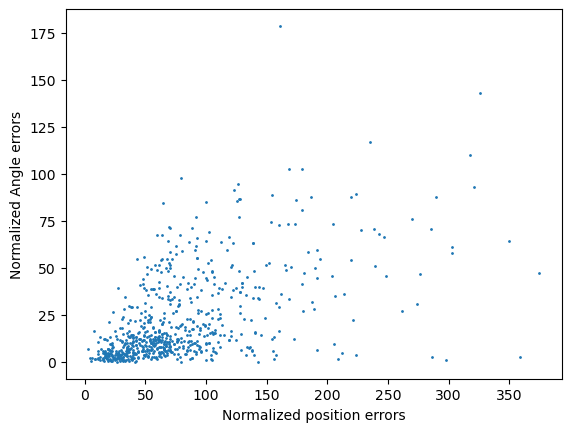

In [6]:
plt.scatter(X_not_missed[:, 0], X_not_missed[:, 1], s=1)
plt.xlabel("Normalized position errors")
plt.ylabel("Normalized Angle errors")
plt.plot()

Plot the intersection distance and distance from red aircraft only for trials where the subject completely missed guessing one or more aircrafts. Note that if a subject missed more than 1 aircraft (2 aircrafts for example), it is represented by 2 points on the plot.

[]

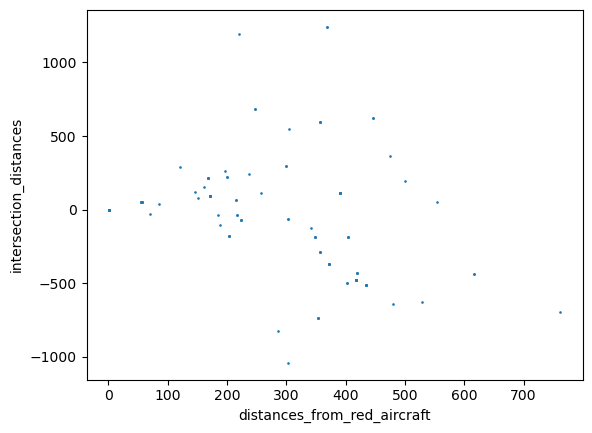

In [ ]:
plt.scatter(X_missed[:, 0], X_missed[:, 1], s = 0.8)
plt.xlabel("distances_from_red_aircraft")
plt.ylabel("intersection_distances")
plt.plot()

Fit a GMM to the normalized data. All trials will be used here since subjects would have guessed position and heading for a subset of aircrafts in the trial. Note that this particular parameter set performed the best for 3 components (Low, medium, and high SA level).

In [8]:
gm = GaussianMixture(n_components=3, covariance_type="full", init_params="k-means++").fit(X_not_missed)
Y_not_missed = gm.predict(X_not_missed)

In [9]:
color_dict = {2: "green", 1: "black", 0: "red"}

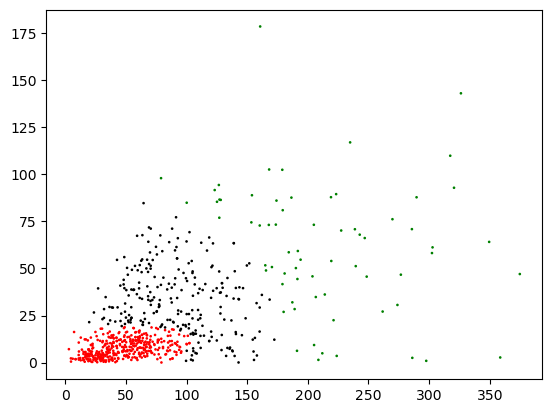

In [10]:
plt.scatter(X_not_missed[:,0], X_not_missed[:, 1], c=[color_dict[label] for label in Y_not_missed], s = 0.8)

In [11]:
unique, counts = np.unique(Y_not_missed, return_counts=True)
dict(zip(unique, counts))

{0: 398, 1: 242, 2: 68}

The generated labels are not usually in the order we need it in. The following few cells handle that

In [12]:
unique, counts = np.unique(Y_not_missed, return_counts=True)
Y_not_missed

array([0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 2, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 2, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 2, 0,
       2, 0, 0, 1, 1, 2, 2, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 0, 2, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [13]:
dict(zip(unique, counts))

{0: 398, 1: 242, 2: 68}

In [14]:
d = {}
d[0] = 2
d[1] = 1
d[2] = 0
d

{0: 2, 1: 1, 2: 0}

In [15]:
Y = np.zeros(Y_not_missed.shape, dtype=np.int64)

In [16]:
for i in range(len(Y)):
    Y[i] = d[Y_not_missed[i]]

In [17]:
Y

array([2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 0, 2, 1, 2,
       2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2,
       1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2,
       2, 2, 0, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1,
       2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2, 2, 1, 2, 1,
       2, 1, 2, 0, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 0, 2, 0, 2,
       0, 2, 2, 1, 1, 0, 0, 1, 0, 1, 1, 2, 1, 2, 1, 2, 1, 2, 0, 1, 1, 2,
       1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1,

In [18]:
unique, counts = np.unique(Y, return_counts=True)
dict(zip(unique, counts))

{0: 68, 1: 242, 2: 398}

In [19]:
color_dict = {2: "green", 1: "black", 0: "red"}

In the plot, the green colored points are subjects with high SA, black with medium SA, and red with low SA. This makes logical sense because the x-axis is normalized position error, and the y-axis is normalized angle error.

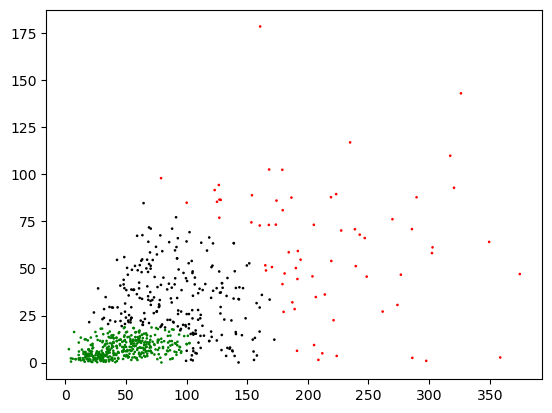

In [20]:
plt.scatter(X_not_missed[:,0], X_not_missed[:, 1], c=[color_dict[label] for label in Y], s = 0.8)

In [21]:
df_not_missed = df_not_missed.assign(not_missed_labels = Y)
df_not_missed.shape

(708, 11)

This is the beginning of the code that incorporates the penalty for missed aircrafts in a trial. Note again that this particular set of parameters was the best for 3 components.

In [22]:
gm = GaussianMixture(n_components=3, covariance_type="diag", init_params="k-means++", random_state=80).fit(X_missed)
Y_missed = gm.predict(X_missed)

In [23]:
color_dict = {2: "red", 1: "black", 0: "green"}

[]

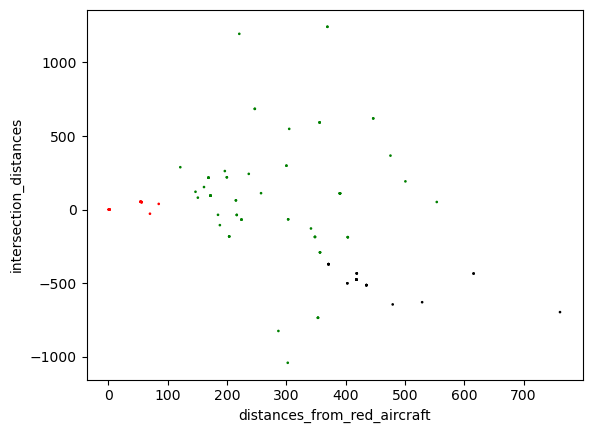

In [24]:
plt.scatter(X_missed[:, 0], X_missed[:, 1], c=[color_dict[label] for label in Y_missed], s = 0.8)
plt.xlabel("distances_from_red_aircraft")
plt.ylabel("intersection_distances")
plt.plot()

In [25]:
unique, counts = np.unique(Y_missed, return_counts=True)
dict(zip(unique, counts))

{0: 71, 1: 28, 2: 32}

In [26]:
d = {}
d[0] = 1
d[1] = 0
d[2] = 2
d

{0: 1, 1: 0, 2: 2}

In [27]:
Y_new = np.zeros(Y_missed.shape, dtype=np.int64)

In [28]:
for i in range(len(Y_new)):
    Y_new[i] = d[Y_missed[i]]

In [29]:
unique, counts = np.unique(Y_new, return_counts=True)
dict(zip(unique, counts))

{0: 28, 1: 71, 2: 32}

In the plot below, the red points correspond to trials where subjects missed an aircraft, and were classified as having low SA because the missed aircraft was either relatively closer in distance to the red one (our aircraft), or the aircraft was on a collision course with the red aircraft.

The red points have label '2' since we will use this later to subtract from the not missed label to obtain the final label. The green points have label '0' so missing these aircrafts does not impact the final label because they are very far from the red aircraft.

Note that there is a point labelled '1' even though it is approximately 500 distance away from the red aircraft. This is because the aircraft was heading directly towards the red aircraft (hence the intersection distance is very small).

[]

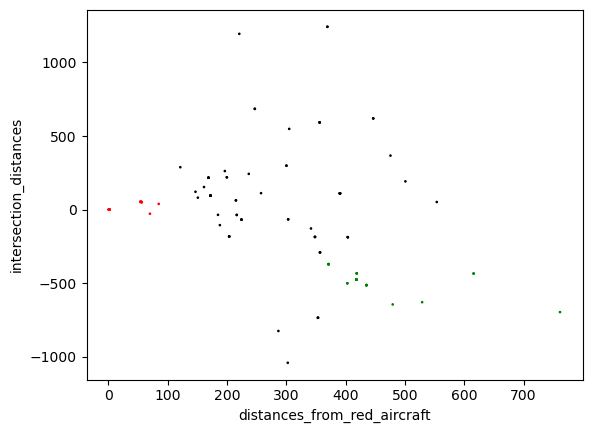

In [30]:
plt.scatter(X_missed[:, 0], X_missed[:, 1], c=[color_dict[label] for label in Y_new], s = 0.8)
plt.xlabel("distances_from_red_aircraft")
plt.ylabel("intersection_distances")
plt.plot()

In [31]:
X_missed

array([[ 5.58032257e+01,  5.13743253e+01],
       [ 3.53305817e+02, -7.34313766e+02],
       [ 4.34994253e+02, -5.12734257e+02],
       [ 3.90385707e+02,  1.10720342e+02],
       [ 3.00093319e+02,  2.98811455e+02],
       [ 4.03600050e+02, -1.86863954e+02],
       [ 3.48242731e+02, -1.85130281e+02],
       [ 2.24289991e+02, -6.74931779e+01],
       [ 1.87856328e+02, -1.04995052e+02],
       [ 5.00801358e+02,  1.92302994e+02],
       [ 3.48242731e+02, -1.85130281e+02],
       [ 1.72037787e+02,  9.52582460e+01],
       [ 1.99612124e+02,  2.19967889e+02],
       [ 3.71109148e+02, -3.70364977e+02],
       [ 2.14895323e+02,  6.32549497e+01],
       [ 1.00000000e+00,  1.00000000e+00],
       [ 5.40832691e+01,  5.38370051e+01],
       [ 1.00000000e+00,  1.00000000e+00],
       [ 5.40832691e+01,  5.38370051e+01],
       [ 1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00],
       [ 1.61074517e+02,  1.53764177e+02],
       [ 4.

In [32]:
df_missed = df_missed.assign(Missed_Labels=Y_new)

The following code uses pandas to merge the df_not_missed and df_missed dataframes together.

In [33]:
df_missed.head(5)

,name,position_error,angle_error,normalized_position_error,normalized_angle_error,num_aircrafts_for_normalization,number_of_missed_aircrafts,intersection_distances,distances_from_red_aircraft,num_aircrafts,Missed_Labels
9,./1566954358/Task_1_5_5_secondary.json,269.672069,113.809939,53.934414,22.761988,5,1,51.374325,55.803226,6,2
10,./1566954358/Task_1_5_1_secondary.json,456.755839,386.092860,91.351168,77.218572,5,1,-734.313766,353.305817,6,1
13,./1566954358/Task_1_5_2.json,364.941579,131.344219,72.988316,26.268844,5,1,-512.734257,434.994253,6,0
18,./1566954358/Task_1_5_4_secondary.json,896.449236,404.838390,179.289847,80.967678,5,1,110.720342,390.385707,6,1
26,./1566954358/Task_1_5_7.json,352.163964,257.256188,70.432793,51.451238,5,1,298.811455,300.093319,6,1


In [34]:
df_missed = df_missed.drop(labels=["intersection_distances", "distances_from_red_aircraft"], axis=1)

In [40]:
df_missed.head(5)

,name,position_error,angle_error,normalized_position_error,normalized_angle_error,num_aircrafts_for_normalization,number_of_missed_aircrafts,num_aircrafts,Missed_Labels
9,./1566954358/Task_1_5_5_secondary.json,269.672069,113.809939,53.934414,22.761988,5,1,6,2
10,./1566954358/Task_1_5_1_secondary.json,456.755839,386.092860,91.351168,77.218572,5,1,6,1
13,./1566954358/Task_1_5_2.json,364.941579,131.344219,72.988316,26.268844,5,1,6,0
18,./1566954358/Task_1_5_4_secondary.json,896.449236,404.838390,179.289847,80.967678,5,1,6,1
26,./1566954358/Task_1_5_7.json,352.163964,257.256188,70.432793,51.451238,5,1,6,1


In [36]:
# aggregation_functions = {'name': 'first', 'position_error': 'first', 'angle_error': 'first', 'normalized_position_error': 'first'}
aggregation_functions = {'Missed_Labels': 'sum'}
df_new = df_missed.groupby(df_missed['name']).aggregate(aggregation_functions)

In [37]:
df_new = df_new.reset_index()

In [38]:
df_new.head()

,name,Missed_Labels
0,./1008719828/Task_1_5_10_secondary.json,1
1,./1008719828/Task_1_5_2.json,0
2,./1008719828/Task_1_5_3_secondary.json,2
3,./1008719828/Task_1_5_4.json,1
4,./1008719828/Task_1_5_5_secondary.json,2


In [39]:
df_not_missed = df_not_missed.drop(labels=["intersection_distances", "distances_from_red_aircraft"], axis=1)

,name,position_error,angle_error,normalized_position_error,normalized_angle_error,num_aircrafts_for_normalization,number_of_missed_aircrafts,num_aircrafts,not_missed_labels
0,./1566954358/Task_1_1_1_secondary.json,62.149627,9.715358,31.074813,4.857679,2,0,2,2
1,./1566954358/Task_1_3_6.json,260.005346,61.313904,65.001336,15.328476,4,0,4,2
2,./1566954358/Task_1_3_1.json,246.825476,32.006403,61.706369,8.001601,4,0,4,2
3,./1566954358/Task_1_1_7_secondary.json,126.646193,67.696985,63.323097,33.848492,2,0,2,1
4,./1566954358/Task_1_5_9_secondary.json,575.248075,230.974696,95.874679,38.495783,6,0,6,1
5,./1566954358/Task_1_1_9.json,143.254472,10.219988,71.627236,5.109994,2,0,2,2
6,./1566954358/Task_1_5_6_secondary.json,295.261893,123.038283,49.210315,20.506381,6,0,6,1
7,./1566954358/Task_1_1_8.json,73.392391,10.636637,36.696195,5.318318,2,0,2,2
8,./1566954358/Task_1_1_10_secondary.json,62.129032,2.350205,31.064516,1.175102,2,0,2,2
9,./1566954358/Task_1_5_5_secondary.json,269.672069,113.809939,53.934414,22.761988,5,1,6,1


In [ ]:
df_not_missed.head(200)

In [45]:
aggregation_functions = {'name': 'first', 'position_error': 'first', 'angle_error': 'first', 'normalized_position_error': 'first', 'normalized_angle_error': 'first', 'num_aircrafts_for_normalization': 'first', 'number_of_missed_aircrafts': 'first', 'num_aircrafts': 'first', 'not_missed_labels': 'first'}
df_not_missed = df_not_missed.groupby(df_not_missed['name']).aggregate(aggregation_functions)
df_not_missed.shape

(693, 9)

Note that the size went down from 708 to 693. This is because the input errors_dataframe.csv had a row for every missed aircraft - so if 2 aircrafts were missed during a single trail, errors_dataframe.csv would have two lines with identical data, apart from the columns "intersection_distance" and "distance_from_red_aircraft".

In [46]:
df_not_missed.head()

,name,position_error,angle_error,normalized_position_error,normalized_angle_error,num_aircrafts_for_normalization,number_of_missed_aircrafts,num_aircrafts,not_missed_labels
name,,,,,,,,,
./1008719828/Task_1_1_10_secondary.json,./1008719828/Task_1_1_10_secondary.json,108.944051,2.773462,54.472025,1.386731,2,0,2,2
./1008719828/Task_1_1_1_secondary.json,./1008719828/Task_1_1_1_secondary.json,22.564032,11.734916,11.282016,5.867458,2,0,2,2
./1008719828/Task_1_1_2.json,./1008719828/Task_1_1_2.json,44.057096,11.682402,22.028548,5.841201,2,0,2,2
./1008719828/Task_1_1_3.json,./1008719828/Task_1_1_3.json,35.277980,6.857112,17.638990,3.428556,2,0,2,2
./1008719828/Task_1_1_4.json,./1008719828/Task_1_1_4.json,98.397408,23.829007,49.198704,11.914503,2,0,2,2


In [47]:
df_not_missed = df_not_missed.drop('name', axis=1)

In [48]:
df_not_missed = df_not_missed.reset_index()

In [49]:
df_not_missed.shape

(693, 9)

In [ ]:
df_not_missed.head(100)

In [ ]:
df_new.head(100)

In [52]:
merged_df = df_not_missed.merge(df_new, on='name', how='left')

Merge the two dataframes

In [53]:
merged_df["Missed_Labels"] = merged_df["Missed_Labels"].fillna(0)

In [55]:
merged_df["Missed_Labels"].value_counts()

Missed_Labels
0.0    596
1.0     61
2.0     35
4.0      1
Name: count, dtype: int64

In [ ]:
merged_df.head(100)

Subtract missed label from not_missed label

In [60]:
merged_df["labels"] = merged_df["not_missed_labels"] - merged_df["Missed_Labels"]

In [61]:
merged_df["labels"].value_counts()

labels
 2.0    355
 1.0    193
 0.0    125
-1.0     16
-2.0      4
Name: count, dtype: int64

If the SA value is < 0, then it is reset to 0 (the lowest SA level)

In [62]:
merged_df['labels'] = merged_df['labels'].where(merged_df['labels'] >= 0, 0)

In [65]:
print(merged_df["labels"].value_counts())
merged_df["labels"] = merged_df["labels"].astype(int)

labels
2    355
1    193
0    145
Name: count, dtype: int64


In [66]:
merged_df.head()

,name,position_error,angle_error,normalized_position_error,normalized_angle_error,num_aircrafts_for_normalization,number_of_missed_aircrafts,num_aircrafts,not_missed_labels,Missed_Labels,labels
0,./1008719828/Task_1_1_10_secondary.json,108.944051,2.773462,54.472025,1.386731,2,0,2,2,0.0,2
1,./1008719828/Task_1_1_1_secondary.json,22.564032,11.734916,11.282016,5.867458,2,0,2,2,0.0,2
2,./1008719828/Task_1_1_2.json,44.057096,11.682402,22.028548,5.841201,2,0,2,2,0.0,2
3,./1008719828/Task_1_1_3.json,35.277980,6.857112,17.638990,3.428556,2,0,2,2,0.0,2
4,./1008719828/Task_1_1_4.json,98.397408,23.829007,49.198704,11.914503,2,0,2,2,0.0,2


Save results to a csv.

In [67]:
merged_df.to_csv("./situation_awareness_labels.csv", index=False)

Check if it has been saved correctly

In [2]:
df_SA = pd.read_csv("situation_awareness_labels.csv")
df_SA.shape

(693, 11)

In [3]:
X = df_SA[['normalized_position_error', "normalized_angle_error"]].to_numpy()

In [4]:
Y = df_SA['labels'].to_numpy()

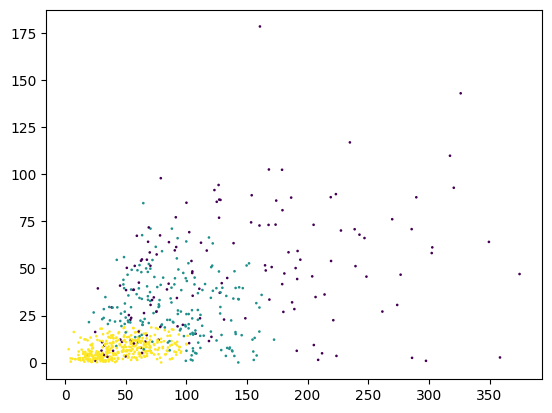

In [5]:
plt.scatter(X[:, 0], X[:, 1], c = Y, s = 0.8)

In [6]:
df_SA["labels"].value_counts()

labels
2    355
1    193
0    145
Name: count, dtype: int64